In [5]:
#import mesma 
import rasterio
import matplotlib.pyplot as plt
import os
import numpy as np
import cupy as cp
import random
from scipy.ndimage import binary_dilation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10833333333333334..1.615].


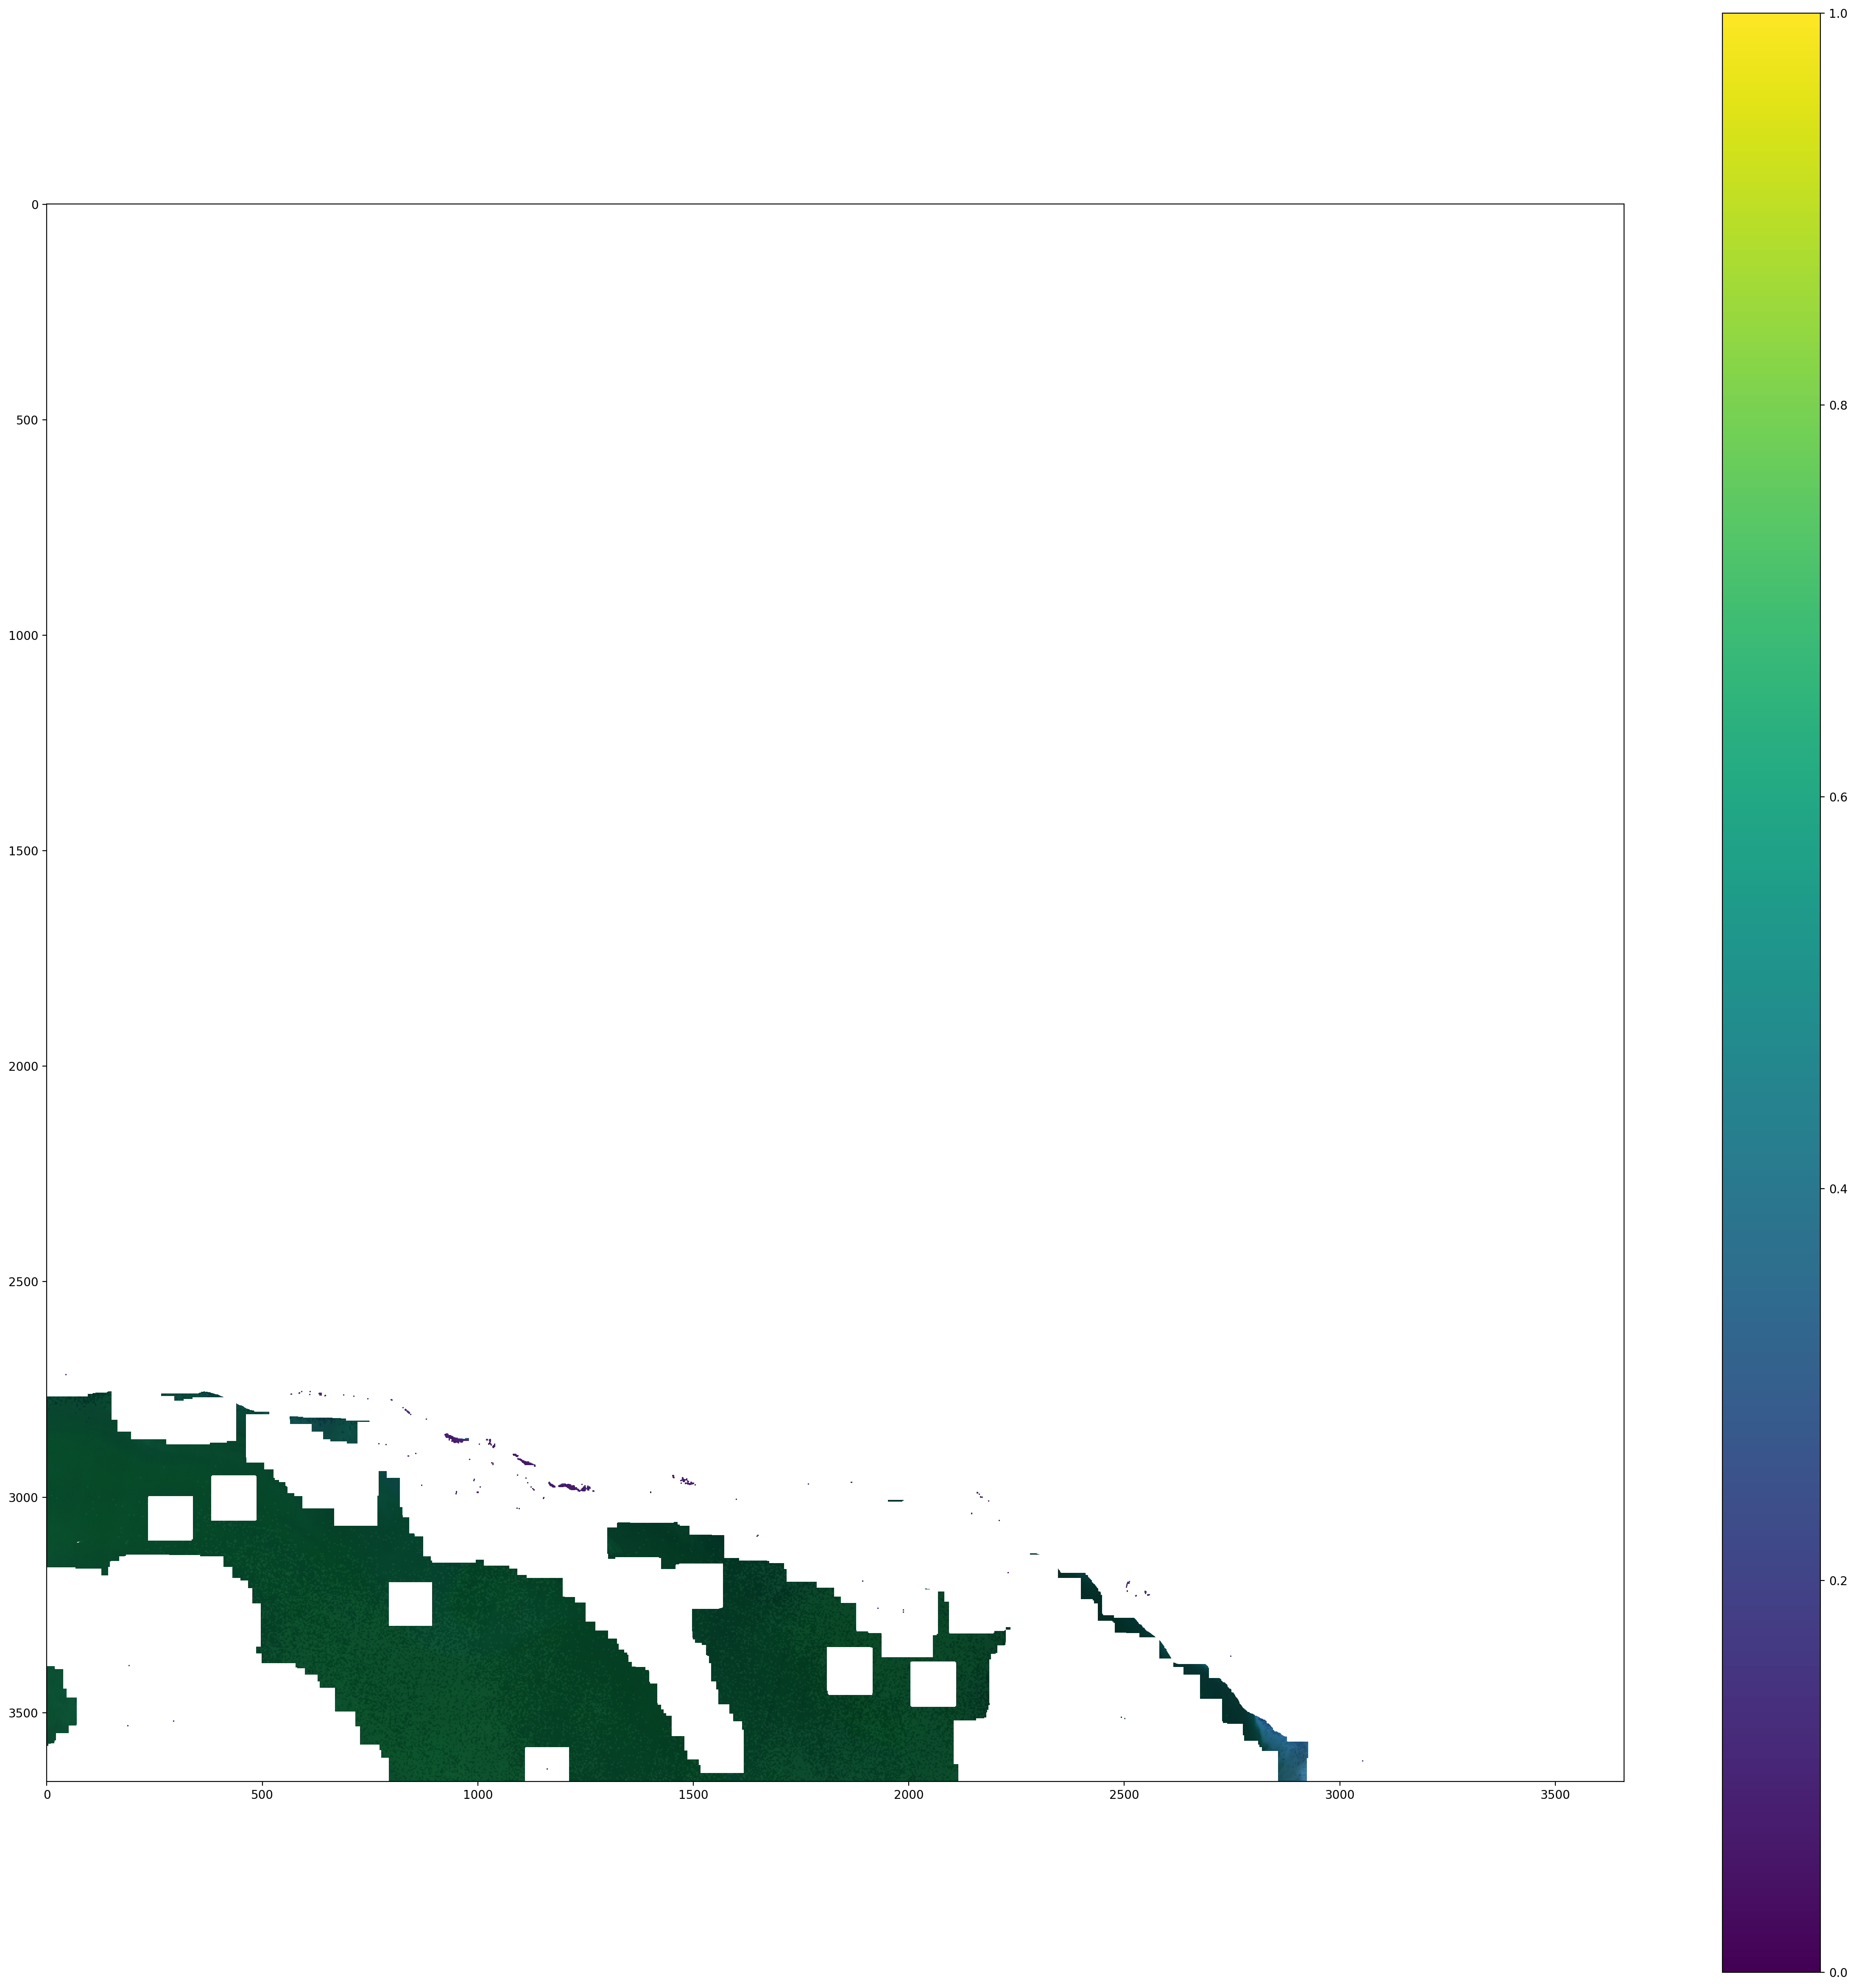

In [6]:
path = r'/mnt/c/Users/attic/HLS_Kelp/imagery/rf_classified_cuML/HLS.L30.T11SKU.2019077T183342.v2.0_rf_ready.tif_kelp_classified.tif'
ocean_dilation = np.ones((100,100)) #Struct for dilation (increase to enlarge non-ocean mask) larger --> takes longer
kelp_dilation = np.ones((4,4))
with rasterio.open(path) as imagery:
    classified_img = imagery.read(5)
    kelp_mask  = []
    ocean_mask = []
    ocean_dilated = np.where(classified_img == 1, False, True)
    ocean_dilated = binary_dilation(ocean_dilated, structure=ocean_dilation) #This takes ~25 seconds. Should look to optimize 
    kelp_dilated = np.where(classified_img == 0, True, False) #This is expanding hte kelp_mask so the TF is reversed
    kelp_dilated = binary_dilation(kelp_dilated,structure=kelp_dilation) #I may not want to do this. we'll see
    for i in range(4):
        band_data = imagery.read(i + 1)
        kmask = np.where(kelp_dilated == True, band_data, np.nan)
        omask = np.where(ocean_dilated == False, band_data, np.nan)
        kelp_mask.append(kmask)
        ocean_mask.append(omask)

    kelp_mask = np.array(kelp_mask)
    ocean_mask = np.array(ocean_mask)
    #print(ocean_mask)

rgb_nor = np.stack([ocean_mask[2]/600,ocean_mask[0]/600,ocean_mask[1]/600], axis=-1)
rgb_nor_cropped = rgb_nor
#print(kelp_mask)
rgb_nor_cropped = np.ma.masked_where(np.isnan(rgb_nor_cropped), rgb_nor_cropped)
image = kelp_mask[1]#,2500:3500,800:1800]
plt.figure(figsize=(30, 30), dpi=200)
plt.imshow(image, alpha=1)
plt.imshow(rgb_nor_cropped, alpha=1)
plt.colorbar()
plt.show()



In [7]:
ocean_EM_stack = []
kelp_EM = [459, 556, 437, 1227]
n_bands, height, width = kelp_mask.shape
ocean_EM_n = 0
ocean_data = ocean_mask.reshape(ocean_mask.shape[0], -1)
kelp_data = kelp_mask.reshape(kelp_mask.shape[0],-1)

nan_columns = np.isnan(ocean_data).any(axis=0)
# Remove columns with NaN values
filtered_ocean = ocean_data[:, ~nan_columns]
for i in range(30):
     index = random.randint(0,len(filtered_ocean[0])-1)
     ocean_EM_stack.append(filtered_ocean[:,index])
ocean_EM = np.stack(ocean_EM_stack, axis=1)
#print(ocean_EM_array)


average_val = np.nanmean(filtered_ocean, axis=1)
average_endmember = np.nanmean(ocean_EM, axis=1)
print(f"average EM Val: {average_endmember}")
print(f"average    Val: {average_val}")

(4, 3660, 3660)
4
(4, 13395600)
average EM Val: [164.13333333  95.5         17.16666667  -0.86666667]
average    Val: [163.74678317  98.79651069  18.34269919  -0.84037978]


In [13]:
kelp_mask = cp.asarray(kelp_mask)
ocean_EM = cp.asarray(ocean_EM)
kelp_EM = cp.asarray(kelp_EM)
kelp_data = cp.asarray(kelp_data)

frac1 = cp.full((kelp_mask.shape[1], kelp_mask.shape[2], 30), cp.nan)
frac2 = cp.full((kelp_mask.shape[1], kelp_mask.shape[2], 30), cp.nan)
rmse = cp.full((kelp_mask.shape[1], kelp_mask.shape[2], 30), cp.nan)
print(rmse.shape)

#print("Running MESMA")
for k in range(30):
    B = cp.column_stack((ocean_EM[:, k], kelp_EM))
    U, S, Vt = cp.linalg.svd(B, full_matrices=False)
    IS = Vt.T / S
    em_inv = IS @ U.T
    F = em_inv @ kelp_data
    model = (F.T @ B.T).T
    resids = (kelp_data - model) / 10000
    rmse[:, :, k] = cp.sqrt(cp.mean(resids**2, axis=0)).reshape(height, width)
    frac1[:, :, k] = F[0, :].reshape(height, width)
    frac2[:, :, k] = F[1, :].reshape(height, width)
    #print(f'Percent MESMA {round(100/30 * (k+1))}%')

(3660, 3660, 30)
Running MESMA
Percent MESMA 3%
Percent MESMA 7%
Percent MESMA 10%
Percent MESMA 13%
Percent MESMA 17%
Percent MESMA 20%
Percent MESMA 23%
Percent MESMA 27%
Percent MESMA 30%
Percent MESMA 33%
Percent MESMA 37%
Percent MESMA 40%
Percent MESMA 43%
Percent MESMA 47%
Percent MESMA 50%
Percent MESMA 53%
Percent MESMA 57%
Percent MESMA 60%
Percent MESMA 63%
Percent MESMA 67%
Percent MESMA 70%
Percent MESMA 73%
Percent MESMA 77%
Percent MESMA 80%
Percent MESMA 83%
Percent MESMA 87%
Percent MESMA 90%
Percent MESMA 93%
Percent MESMA 97%
Percent MESMA 100%


In [18]:

minVals = cp.nanmin(rmse, axis=2)
PageIdx = cp.nanargmin(rmse, axis=2)

rows, cols = cp.meshgrid(cp.arange(rmse.shape[0]), cp.arange(rmse.shape[1]), indexing='ij')

Zindex = cp.ravel_multi_index((rows, cols, PageIdx), dims=rmse.shape)

Mes2 = frac2.ravel()[Zindex]
Mes2 = Mes2.T

Mes2 = -0.229 * Mes2**2 + 1.449 * Mes2 - 0.018 #Landsat mesma corrections 

Mes2 = cp.clip(Mes2, 0, None)  # Ensure no negative values
Mes2 = cp.round(Mes2 * 100).astype(cp.int16)


/home/atticus/miniconda3/envs/rapids-24.06/lib/python3.9/site-packages/cupy/_statistics/order.py:111: RuntimeWarning: All-NaN slice encountered
  warnings.warn('All-NaN slice encountered', RuntimeWarning)


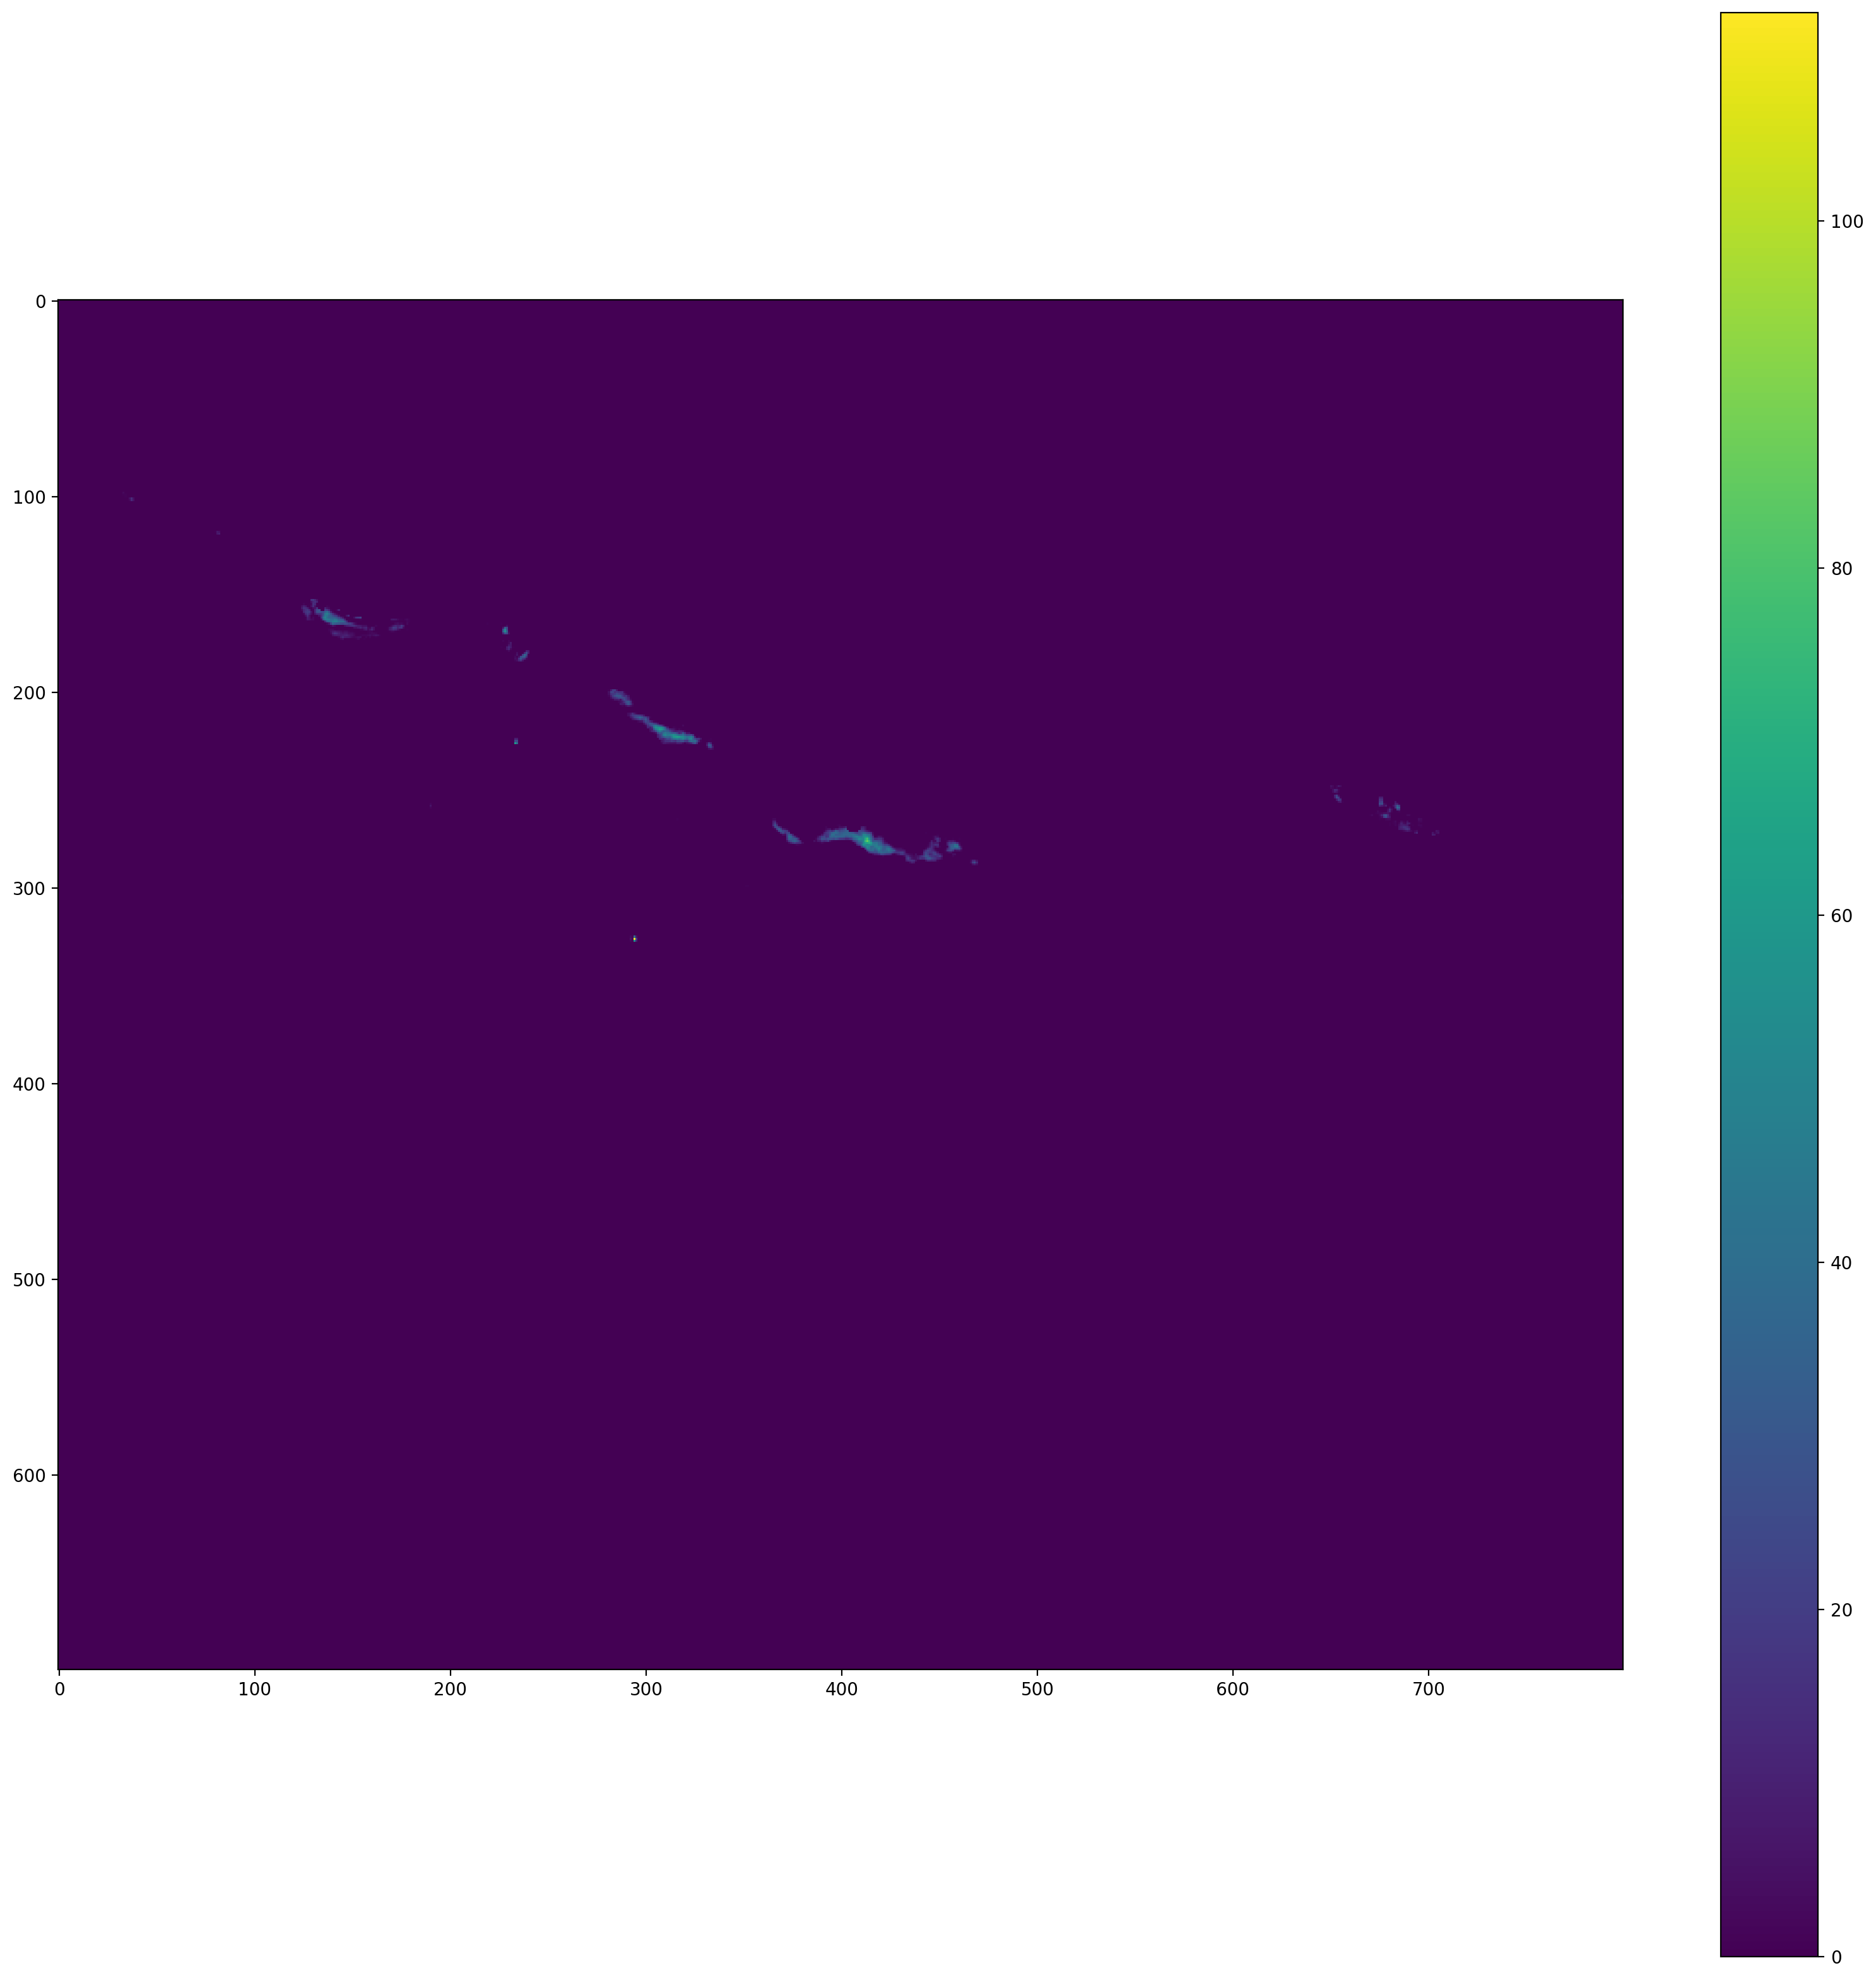

In [21]:
Mes_array = cp.asnumpy(Mes2).T

plt.figure(figsize=(20, 20), dpi=200)
plt.imshow(Mes_array[2700:3400,800:1600], alpha=1)
plt.colorbar()
plt.show()